# BAI (Blank Artificial Intelligence)

## Introduction

BAI is a model trained to detect blank vs. non-blank scans of paper. The intention was to design a program that could automatically filter out empty pages of paper from scans. You can find the pretrained model on the [github repository](https://www.github.com/RaspberryProgramming/BAI). There is a planned addition to my website where you can potentially access the model online and upload photos that the ai can detect as blank or not.

## Disclaimer

This dataset used to train the model is contained within the repository. You can use this or add to it in order to improve your own model. This model may not be as optimized as you could get it so you're welcome to submit commits to help in the project.

## Install Requirements

In [1]:
# Uncomment if needed. I'll leave this commented to save time
# !pip3 install tensorflow numpy pandas seaborn matplotlib tensorflowjs

## Load necessary libraries

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread

# Technically not necessary in newest versions of jupyter
%matplotlib inline

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

## Generate paths to training and testing folders in the dataset

In [3]:
my_data_dir = './dataset'

In [4]:
test_path = my_data_dir+'/test/'
train_path = my_data_dir+'/train/'

## ImageDataGenerator
Used to account for images that aren't so perfect as what was originally uploaded.

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
image_gen = ImageDataGenerator(rotation_range=3, # rotate the image 3 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 10%
                               height_shift_range=0.10, # Shift the pic height by a max of 10%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

## Create the model

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

In [7]:
# Image Shape
image_shape=(550, 425, 3)

#https://stats.stackexchange.com/questions/148139/rules-for-selecting-convolutional-neural-network-hyperparameters
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())

# Doesn't need to be on the same line
# Replaces model.add(Dense(128, activation='relu'))
model.add(Dense(128))
model.add(Activation('relu'))

# Dropouts help reduce overfitting by randomly turning neurons off during training.
# Here we say randomly turn off 50% of neurons.
model.add(Dropout(0.5))

# Last layer, remember its binary so we use sigmoid
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', # Binary Classification Problem
              optimizer='adam',
              metrics=['accuracy']) # Accuracy is optimal for this type of input

In [8]:
batch_size = 32 # Number of images to process at a time

In [9]:
train_image_gen = image_gen.flow_from_directory(train_path,
                                               target_size=image_shape[:2],
                                                color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary') # Because we're using binary classification
                                                                    # Also there are only 2 classes

Found 101 images belonging to 2 classes.


In [10]:
test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary',shuffle=False) # Not needed, may remove from original classifications

Found 94 images belonging to 2 classes.


In [11]:
train_image_gen.class_indices

{'blank': 0, 'full': 1}

## Setup Early Stopping
This can be used to prevent us from running more epochs than necessary. This will enable us to set epochs to 110 but still run the optimal amount. (May not run 110 epochs)

In [12]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=10)

In [13]:
results = model.fit(train_image_gen,epochs=110,
                    validation_data=test_image_gen,
                    callbacks=[early_stop])

Epoch 1/110
4/4 [==============================] - 10s 2s/step - loss: 8.8940 - accuracy: 0.7129 - val_loss: 0.8156 - val_accuracy: 0.2553
Epoch 2/110
4/4 [==============================] - 6s 2s/step - loss: 0.8151 - accuracy: 0.6436 - val_loss: 0.5537 - val_accuracy: 0.7447
Epoch 3/110
4/4 [==============================] - 6s 2s/step - loss: 0.7348 - accuracy: 0.6139 - val_loss: 0.5315 - val_accuracy: 0.7447
Epoch 4/110
4/4 [==============================] - 6s 2s/step - loss: 0.6503 - accuracy: 0.7426 - val_loss: 0.5252 - val_accuracy: 0.7447
Epoch 5/110
4/4 [==============================] - 6s 2s/step - loss: 0.5528 - accuracy: 0.7426 - val_loss: 0.6748 - val_accuracy: 0.7447
Epoch 6/110
4/4 [==============================] - 6s 2s/step - loss: 0.6073 - accuracy: 0.7426 - val_loss: 0.5599 - val_accuracy: 0.7447
Epoch 7/110
4/4 [==============================] - 6s 2s/step - loss: 0.5641 - accuracy: 0.7426 - val_loss: 0.5177 - val_accuracy: 0.7447
Epoch 8/110
4/4 [================

## Save the model
The model is also saved for js version of tensorflow (written into the bai_js folder)

In [14]:
from tensorflow.keras.models import load_model
model.save('bai.h5')

In [15]:
!tensorflowjs_converter --input_format=keras ./bai.h5 ./bai_js

## Analyze our progress

<AxesSubplot:>

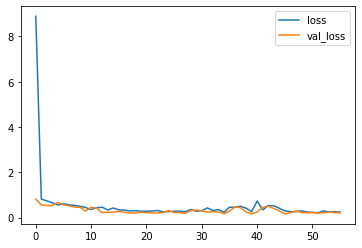

In [16]:
losses = pd.DataFrame(model.history.history)
losses[['loss','val_loss']].plot()

In [17]:
model.evaluate_generator(test_image_gen)

<ipython-input-17-31acfd80dad9>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(test_image_gen)


[0.2016652226448059, 0.9680851101875305]

In [18]:
from tensorflow.keras.preprocessing import image
# https://datascience.stackexchange.com/questions/13894/how-to-get-predictions-with-predict-generator-on-streaming-test-data-in-keras
pred_probabilities = model.predict_generator(test_image_gen)
pred_probabilities

<ipython-input-18-7135325772ed>:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred_probabilities = model.predict_generator(test_image_gen)


array([[0.01313462],
       [0.4307277 ],
       [0.4307277 ],
       [0.4307277 ],
       [0.4307277 ],
       [0.4307277 ],
       [0.4307277 ],
       [0.4307277 ],
       [0.4307277 ],
       [0.4307277 ],
       [0.4307277 ],
       [0.4307277 ],
       [0.4307277 ],
       [0.43079343],
       [0.4307277 ],
       [0.4307277 ],
       [0.43064097],
       [0.4307277 ],
       [0.4307277 ],
       [0.41595015],
       [0.4307277 ],
       [0.4307277 ],
       [0.4307277 ],
       [0.4651896 ],
       [1.        ],
       [1.        ],
       [1.        ],
       [0.9952519 ],
       [0.99997866],
       [0.96737427],
       [1.        ],
       [1.        ],
       [1.        ],
       [0.9999999 ],
       [1.        ],
       [0.9999999 ],
       [1.        ],
       [0.99999964],
       [0.9864007 ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [0.9999993 ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.   

In [19]:
test_image_gen.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1], dtype=int32)

In [20]:
predictions = pred_probabilities > 0.5
predictions

array([[False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [

 # Testing Via Reading an Image

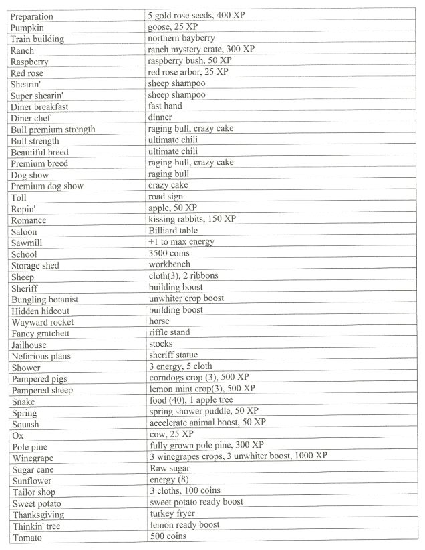

In [21]:
impath = "./dataset/test/full/192m5d65m62x9jpg.jpg"
my_image = image.load_img(impath,target_size=image_shape)
my_image

In [22]:
my_image = image.img_to_array(my_image)
my_image = np.expand_dims(my_image, axis=0)
model.predict(my_image)

array([[1.]], dtype=float32)

In [23]:
test_image_gen.class_indices

{'blank': 0, 'full': 1}